In [17]:
import numpy as np

from torch_traj_utils.load_training_dataset import load_dataset_np
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn

In [2]:
os.getcwd()

'/home/sjohnson/cartpole_nn/notebooks'

In [3]:
x,y,z,id,od=load_dataset_np("../scripts/trajectories_big_1_training.npz")

(201460, 4) (201460, 1) (2878, 4)


In [4]:
x.shape

(201460, 4)

In [6]:
df = pd.DataFrame(x,columns=['x','theta','xdot','thetadot'])

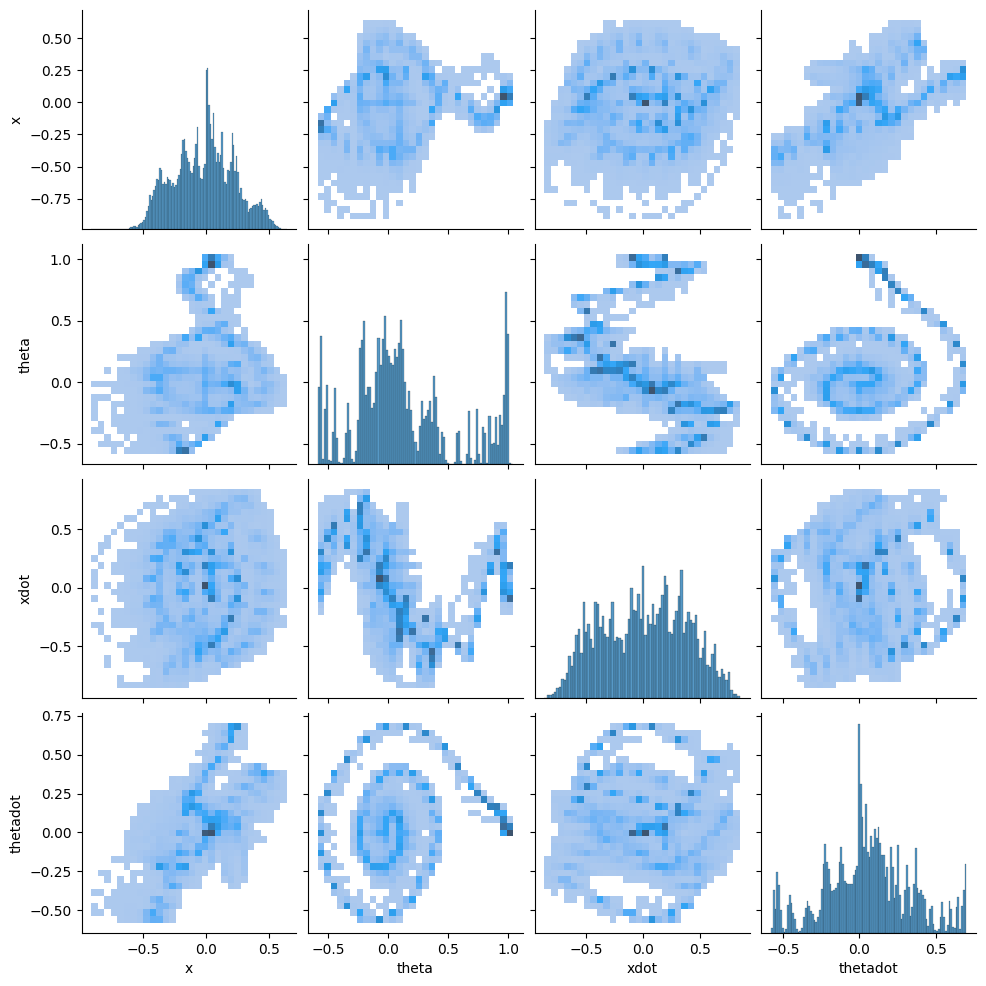

In [14]:
sn.pairplot(df, kind="hist", plot_kws={"bins": 30})

In [19]:
xy = np.hstack((x,y))

In [20]:
df_xy = pd.DataFrame(xy,columns=['x','theta','xdot','thetadot','u'])

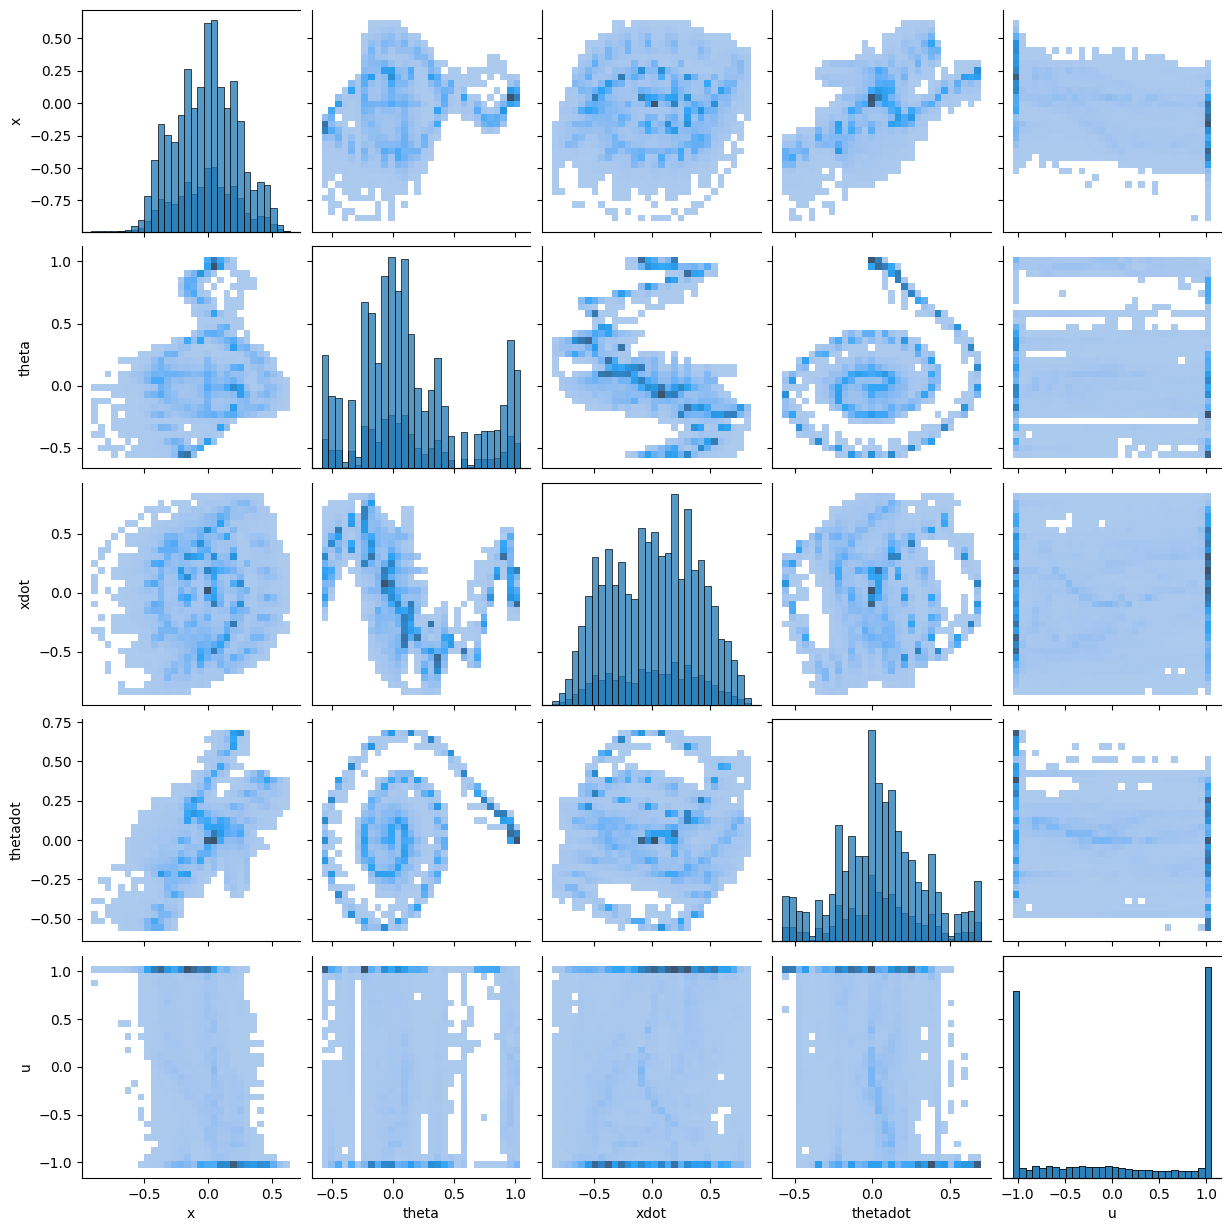

In [38]:
g = sn.pairplot(df_xy, kind="hist", diag_kind="hist", diag_kws={"bins": 30}, plot_kws={"bins": 30})
# seaborn's diagonal histograms are broken
# Replace each diagonal plot with an independent-y "twin" axis
cols = df_xy.columns

for i, col in enumerate(cols):
    ax = g.axes[i, i]

    # Grab x-limits before we mess with anything
    xlim = ax.get_xlim()

    # Create independent y axis that shares x
    ax2 = ax.twinx()

    # Remove existing artists *without* clearing the axis object
    # histplot/hist can populate patches and sometimes collections
    for p in list(ax.patches):
        p.remove()
    for c in list(ax.collections):
        c.remove()
    for ln in list(ax.lines):
        ln.remove()

    # Plot the diagonal histogram onto the twin axis
    sn.histplot(df_xy[col], bins=30, stat="count", ax=ax2)

    # # Make it look like a normal left-y-axis plot
    # ax2.yaxis.set_ticks_position("left")
    # ax2.yaxis.set_label_position("left")
    ax2.set_ylabel("")                          # remove "Count" label
    ax2.tick_params(right=False, labelright=False)
    ax2.spines["right"].set_visible(False)

    # Keep the x-limits consistent with the grid
    ax2.set_xlim(xlim)


plt.show()


In [40]:
# a wee bit of clustering
import umap

/home/sjohnson/cartpole_nn/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [41]:
reducer = umap.UMAP(
    n_neighbors=30,      # try 15–50
    min_dist=0.05,       # small = sharper clusters
    n_components=2,
    metric="euclidean",
    random_state=0,
)

In [43]:
Z_emb = reducer.fit_transform(xy)

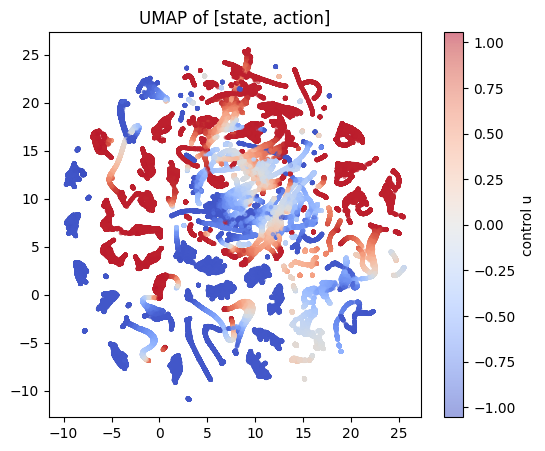

In [45]:
plt.figure(figsize=(6, 5))
plt.scatter(Z_emb[:, 0], Z_emb[:, 1],
            s=5, alpha=0.5, c=y.squeeze(),
            cmap="coolwarm")
plt.colorbar(label="control u")
plt.title("UMAP of [state, action]")
plt.show()

In [67]:
umax = np.max(np.abs(np.squeeze(y)))
eps = 0.9 * umax
labels = np.zeros_like(np.squeeze(y), dtype=int)
labels[np.squeeze(y) >  eps] =  1
labels[np.squeeze(y) < -eps] = -1
uv, cts = np.unique(labels,return_counts=True)
print(umax)
print(uv)
print(cts)
print(cts/np.sum(cts))


1.0551390049381815
[-1  0  1]
[58925 76002 66533]
[0.29248982 0.37725603 0.33025414]


In [64]:
from sklearn.neighbors import NearestNeighbors
k = 25
nbrs = NearestNeighbors(n_neighbors=k).fit(x)
idx = nbrs.kneighbors(return_distance=False)

consistency = ((y[idx]-y[:,None])<=0.05).mean(axis=1)
#consistency = (labels[idx]==labels[:,None]).mean(axis=1)
print("Mean kNN label consistency:", consistency.mean())

Mean kNN label consistency: 0.9167477414871439


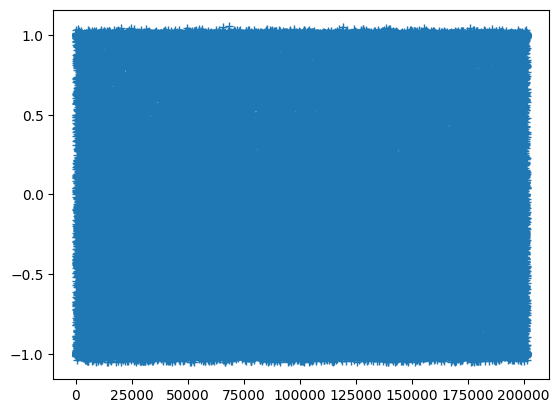

1.0551390049381815

In [70]:
plt.figure()
plt.plot(y, '+')
plt.show()
np.max(y)

In [73]:
len(os.listdir("../scripts/trajectories_big_2"))

4096

In [72]:
os.getcwd()

'/home/sjohnson/cartpole_nn/notebooks'